In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter

from IPython.display import HTML

# local import
import nflplot
import nflutil
import nfl_bdb22

In [11]:
from importlib import reload
reload(nflplot)
reload(nflutil)
reload(nfl_bdb22)

<module 'nfl_bdb22' from 'C:\\Users\\pschl\\Documents\\data_science\\kaggle_nfl_bdb_2022\\nfl_bdb22.py'>

**IMPORT DATA - This notebook assumes that the source data is in a "csv" subfolder relative to this notebook**

In [4]:
year = 2018
track_df = nflutil.transform_tracking_data(pd.read_csv(f'csv/tracking{year}.csv'))

In [5]:
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
pff_df = pd.read_csv('csv/PFFScoutingData.csv')

### Filter data to plays relevant for modeling
Clean catch and return

In [38]:
def prep_get_modeling_frames(track_df, play_df, pff_df):
    clean_track_df = (
        track_df
        # filter down to punt plays with a return
        .merge(play_df.loc[(play_df.specialTeamsPlayType=='Punt') & (play_df.specialTeamsResult=='Return'), ['gameId','playId']],
               how='inner',
               on=['gameId','playId']
              )
        # filter down to clean catches
        .merge(pff_df.loc[pff_df.kickContactType=='CC', ['gameId','playId']],
               how='inner',
               on=['gameId','playId']
              )
        # filter to all frames between the punt and the catch
        .merge(
            # Dataframe of: gameId, playId, punt (frameId), punt_received (frameId)
            (nflutil.get_frame_of_event(track_df, 
                                   ['punt','punt_received'])
             .pivot(index=['gameId','playId'], columns='event', values='frameId')
             .dropna()  # remove any rows where punt OR punt_received events are not present (both means a valid play)
             .rename(columns={'punt': 'puntFrameId', 'punt_received': 'puntReceivedFrameId'})
             .astype('int64')
             .reset_index()
                ),
            how='left',
            on=['gameId','playId']
            )
        .query('(frameId >= puntFrameId) & (frameId <= puntReceivedFrameId)')
        # debug command - only show 1 row per play
        # .groupby(['gameId','playId']).head(1)
        .drop(columns=['puntFrameId', 'puntReceivedFrameId'])
        .reset_index(drop=True)
    )

    return clean_track_df

In [7]:
modelbase_track_df = nfl_bdb22.prep_get_modeling_frames(track_df, play_df, pff_df)
modelbase_track_df

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T23:12:06.000,30.68,28.52,2.36,0.53,0.24,75.22,78.43,punt,31018.0,Sam Koch,4.0,P,home,32,2018123000,2502,right
1,2018-12-30T23:12:06.100,30.91,28.56,2.28,0.79,0.23,75.93,79.62,None,31018.0,Sam Koch,4.0,P,home,33,2018123000,2502,right
2,2018-12-30T23:12:06.200,31.12,28.60,2.06,1.29,0.21,68.29,80.78,None,31018.0,Sam Koch,4.0,P,home,34,2018123000,2502,right
3,2018-12-30T23:12:06.300,31.30,28.62,1.83,1.68,0.19,64.80,82.73,None,31018.0,Sam Koch,4.0,P,home,35,2018123000,2502,right
4,2018-12-30T23:12:06.400,31.47,28.64,1.62,1.82,0.17,59.27,86.02,None,31018.0,Sam Koch,4.0,P,home,36,2018123000,2502,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778775,2018-09-11T02:40:39.500,66.39,45.14,9.41,4.42,1.09,NaN,NaN,None,NaN,football,NaN,NaN,football,75,2018091001,499,right
778776,2018-09-11T02:40:39.600,67.42,45.17,7.92,6.04,1.03,NaN,NaN,None,NaN,football,NaN,NaN,football,76,2018091001,499,right
778777,2018-09-11T02:40:39.700,68.34,45.18,6.50,7.16,0.92,NaN,NaN,None,NaN,football,NaN,NaN,football,77,2018091001,499,right
778778,2018-09-11T02:40:39.800,69.13,45.20,4.79,8.00,0.79,NaN,NaN,None,NaN,football,NaN,NaN,football,78,2018091001,499,right


In [39]:
(
    modelbase_track_df.groupby(['gameId','playId'])
    .agg(puntFrame=('frameId', 'min'), 
         catchFrame=('frameId', 'max')
        )
    .reset_index()
)

,gameId,playId,puntFrame,catchFrame
0,2018090600,366,33,78
1,2018090600,1989,34,80
2,2018090600,2599,34,77
3,2018090600,3868,34,79
4,2018090900,485,32,78
...,...,...,...,...
749,2018123013,1003,33,76
750,2018123013,3260,33,74
751,2018123015,592,31,74
752,2018123015,1714,29,73


# Features

## Time to catch

In [43]:
# investigative purposes - hang time
ttc_df = nfl_bdb22.feat_timeToCatch(modelbase_track_df).groupby(['gameId','playId'])['timeToCatch'].max().reset_index()
ttc_df

,gameId,playId,timeToCatch
0,2018090600,366,4.5
1,2018090600,1989,4.6
2,2018090600,2599,4.3
3,2018090600,3868,4.5
4,2018090900,485,4.6
...,...,...,...
749,2018123013,1003,4.3
750,2018123013,3260,4.1
751,2018123015,592,4.3
752,2018123015,1714,4.4


<AxesSubplot:xlabel='timeToCatch', ylabel='Count'>

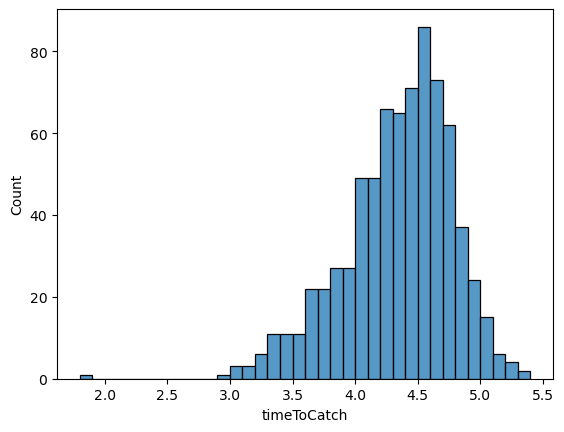

In [44]:
sns.histplot(data=ttc_df, x='timeToCatch',binwidth=0.1)

In [45]:
ttc_df.loc[ttc_df.timeToCatch < 2, :]

,gameId,playId,timeToCatch
243,2018100711,253,1.8


**The play above should be removed from the modeling, it was a tipped play that was caught out of the air.**

In [46]:
bad_plays = [
        # gameId, playId
        (2018100711, 253)
    ]

# modelbase_track_df = prep_remove_abnormal_plays(modelbase_track_df, bad_plays)
modelbase_track_df = nflutil.remove_abnormal_plays(modelbase_track_df, bad_plays)

In [47]:
# generate feature by function
nfl_bdb22.feat_timeToCatch(modelbase_track_df)

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,timeToCatch
0,2018-12-30T23:12:06.000,30.68,28.52,2.36,0.53,0.24,75.22,78.43,punt,31018.0,Sam Koch,4.0,P,home,32,2018123000,2502,right,4.3
1,2018-12-30T23:12:06.100,30.91,28.56,2.28,0.79,0.23,75.93,79.62,None,31018.0,Sam Koch,4.0,P,home,33,2018123000,2502,right,4.2
2,2018-12-30T23:12:06.200,31.12,28.60,2.06,1.29,0.21,68.29,80.78,None,31018.0,Sam Koch,4.0,P,home,34,2018123000,2502,right,4.1
3,2018-12-30T23:12:06.300,31.30,28.62,1.83,1.68,0.19,64.80,82.73,None,31018.0,Sam Koch,4.0,P,home,35,2018123000,2502,right,4.0
4,2018-12-30T23:12:06.400,31.47,28.64,1.62,1.82,0.17,59.27,86.02,None,31018.0,Sam Koch,4.0,P,home,36,2018123000,2502,right,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778338,2018-09-11T02:40:39.500,66.39,45.14,9.41,4.42,1.09,NaN,NaN,None,NaN,football,NaN,NaN,football,75,2018091001,499,right,0.4
778339,2018-09-11T02:40:39.600,67.42,45.17,7.92,6.04,1.03,NaN,NaN,None,NaN,football,NaN,NaN,football,76,2018091001,499,right,0.3
778340,2018-09-11T02:40:39.700,68.34,45.18,6.50,7.16,0.92,NaN,NaN,None,NaN,football,NaN,NaN,football,77,2018091001,499,right,0.2
778341,2018-09-11T02:40:39.800,69.13,45.20,4.79,8.00,0.79,NaN,NaN,None,NaN,football,NaN,NaN,football,78,2018091001,499,right,0.1


## Distance, speed, time-to-close of nearest 4 defenders

In [13]:
temp_df = (modelbase_track_df
 # get location data of returner for each frame for modeling
 .merge(play_df.loc[~play_df.returnerId.astype(str).str.contains(';'), ## only consider plays with 1 returner
                    ['gameId','playId','returnerId']].astype({"returnerId": float}),
        how='inner',
        left_on=['gameId','playId','nflId'],
        right_on=['gameId','playId','returnerId'])
 .filter(['gameId','playId','frameId','team','x','y','puntReceivedFrameId'])
 .rename(columns={'x':'x_returner', 'y':'y_returner', 'team':'teamReturner'})
 # attach the returner data to the rest of the tracking data
 .merge(modelbase_track_df[['gameId','playId','frameId','nflId','team','x','y','s','o','dir']],
        how='inner',
        on=['gameId','playId','frameId'])
 # attach home and away team labels for each game
 .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr']],
        how='inner',
        on='gameId')
 # filter to opposing team players
 .query('teamReturner != team and team != "football"')
 # assemble identifier for punting team players
 .assign(puntTeamAbbr=lambda df_: np.where(df_['team']=='home', df_['homeTeamAbbr'], df_['visitorTeamAbbr']))
 .drop(columns=['teamReturner', 'team', 'homeTeamAbbr', 'visitorTeamAbbr'])
 # calculate distance to returner
 .assign(dist=lambda df_: np.sqrt((df_['x']-df_['x_returner'])**2 + (df_['y']-df_['y_returner'])**2))
 # attach distance order within given play
 .sort_values(['gameId','playId','frameId','dist'])
 # create features
 .assign(distOrder=lambda df_: df_.groupby(['gameId','playId','frameId']).cumcount()+1,
         timeToCatch=lambda df_: (df_.puntReceivedFrameId - df_.frameId)/10,
         timeToClose=lambda df_: df_.dist / np.maximum(df_.s, 0.01),
         upGutLeverage=lambda df_: np.abs(df_.y - df_.y_returner)
        )
 # filter to closest 4 defenders
 .query('distOrder <= 4')
  # attach return yardage (outcome)
 .merge(play_df[['gameId','playId','kickReturnYardage']],
        how='inner',
        on=['gameId','playId'])
)
temp_df

,gameId,playId,frameId,x_returner,y_returner,puntReceivedFrameId,nflId,x,y,s,o,dir,puntTeamAbbr,dist,distOrder,timeToCatch,timeToClose,upGutLeverage,kickReturnYardage
0,2018090600,366,33,65.57,24.00,78,44997.0,18.49,27.44,4.03,59.85,131.06,PHI,47.205508,1,4.5,11.713526,3.44,5.0
1,2018090600,366,33,65.57,24.00,78,32361.0,16.29,27.74,5.61,133.23,127.27,PHI,49.421716,2,4.5,8.809575,3.74,5.0
2,2018090600,366,33,65.57,24.00,78,42942.0,16.71,31.71,1.79,306.86,11.48,PHI,49.464570,3,4.5,27.633838,7.71,5.0
3,2018090600,366,33,65.57,24.00,78,46194.0,22.01,0.17,6.39,85.36,111.60,PHI,49.652215,4,4.5,7.770300,23.83,5.0
4,2018090600,366,34,65.56,23.85,78,44997.0,18.83,27.17,4.43,63.77,128.40,PHI,46.847789,1,4.4,10.575122,3.32,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135227,2018123015,1958,69,76.90,33.00,70,45352.0,60.70,25.79,8.21,67.37,82.99,SEA,17.732008,4,0.1,2.159806,7.21,3.0
135228,2018123015,1958,70,76.85,33.20,70,39232.0,68.15,28.56,4.31,38.78,67.31,SEA,9.860000,1,0.0,2.287703,4.64,3.0
135229,2018123015,1958,70,76.85,33.20,70,41973.0,61.69,32.03,7.91,75.17,87.43,SEA,15.205081,2,0.0,1.922261,1.17,3.0
135230,2018123015,1958,70,76.85,33.20,70,43592.0,60.64,34.89,8.81,67.56,76.47,SEA,16.297859,3,0.0,1.849927,1.69,3.0


<AxesSubplot:xlabel='dist', ylabel='kickReturnYardage'>

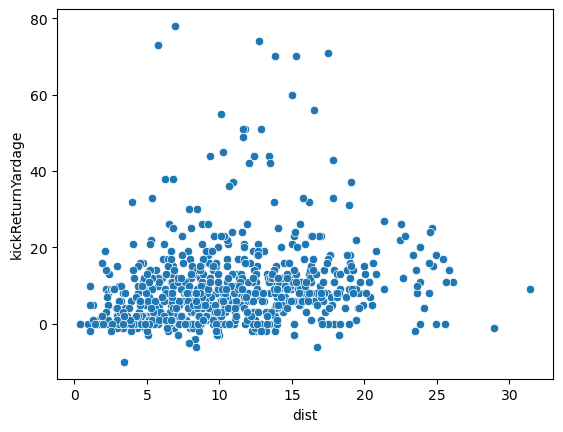

In [14]:
sns.scatterplot(data=temp_df.query('timeToCatch==0.0 & distOrder==1'), x='dist', y='kickReturnYardage')

In [82]:
# created features by function
reload(nfl_bdb22)
nfl_bdb22.feat_byDefender(modelbase_track_df, play_df, game_df, 3)

,gameId,playId,frameId,"(dist, 1)","(dist, 2)","(dist, 3)","(timeToClose, 1)","(timeToClose, 2)","(timeToClose, 3)","(upGutLeverage, 1)","(upGutLeverage, 2)","(upGutLeverage, 3)"
0,2018090600,366,33,47.205508,49.421716,49.464570,11.713526,8.809575,27.633838,3.44,3.74,7.71
1,2018090600,366,34,46.847789,48.938927,49.019066,10.575122,8.337126,7.382389,3.32,3.55,23.68
2,2018090600,366,35,46.468936,48.423946,49.115465,9.824299,7.822931,10.318375,3.18,3.32,6.60
3,2018090600,366,36,46.049793,47.899127,48.620623,9.118771,7.380451,6.809611,3.03,3.08,25.25
4,2018090600,366,37,45.618489,47.363430,47.964756,8.447868,6.965210,6.378292,2.84,2.81,25.17
...,...,...,...,...,...,...,...,...,...,...,...,...
33784,2018123015,1958,66,11.938677,18.622419,20.045453,1.928704,2.279366,2.254832,4.78,0.68,1.49
33785,2018123015,1958,67,11.299314,17.728060,19.075547,2.006983,2.191355,2.143320,4.69,0.80,1.58
33786,2018123015,1958,68,10.739320,16.864033,18.136130,2.077238,2.100129,2.044659,4.63,0.90,1.66
33787,2018123015,1958,69,10.268072,16.033764,17.213164,2.175439,2.027025,1.942795,4.62,1.04,1.69


## Up the gut leverage - min horizontal distance to nearest defender

In [15]:
temp_df[temp_df.distOrder==1]

,gameId,playId,frameId,x_returner,y_returner,puntReceivedFrameId,nflId,x,y,s,o,dir,puntTeamAbbr,dist,distOrder,timeToCatch,timeToClose,upGutLeverage,kickReturnYardage
0,2018090600,366,33,65.57,24.00,78,44997.0,18.49,27.44,4.03,59.85,131.06,PHI,47.205508,1,4.5,11.713526,3.44,5.0
4,2018090600,366,34,65.56,23.85,78,44997.0,18.83,27.17,4.43,63.77,128.40,PHI,46.847789,1,4.4,10.575122,3.32,5.0
8,2018090600,366,35,65.55,23.72,78,44997.0,19.19,26.90,4.73,67.29,125.98,PHI,46.468936,1,4.3,9.824299,3.18,5.0
12,2018090600,366,36,65.55,23.59,78,44997.0,19.60,26.62,5.05,71.86,123.88,PHI,46.049793,1,4.2,9.118771,3.03,5.0
16,2018090600,366,37,65.57,23.49,78,44997.0,20.04,26.33,5.40,79.69,122.25,PHI,45.618489,1,4.1,8.447868,2.84,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135212,2018123015,1958,66,77.17,32.55,70,39232.0,66.23,27.77,6.19,50.76,69.75,SEA,11.938677,1,0.4,1.928704,4.78,3.0
135216,2018123015,1958,67,77.06,32.68,70,39232.0,66.78,27.99,5.63,45.29,67.87,SEA,11.299314,1,0.3,2.006983,4.69,3.0
135220,2018123015,1958,68,76.97,32.82,70,39232.0,67.28,28.19,5.17,42.43,67.16,SEA,10.739320,1,0.2,2.077238,4.63,3.0
135224,2018123015,1958,69,76.90,33.00,70,39232.0,67.73,28.38,4.72,40.65,66.80,SEA,10.268072,1,0.1,2.175439,4.62,3.0


<AxesSubplot:xlabel='upGutLeverage', ylabel='kickReturnYardage'>

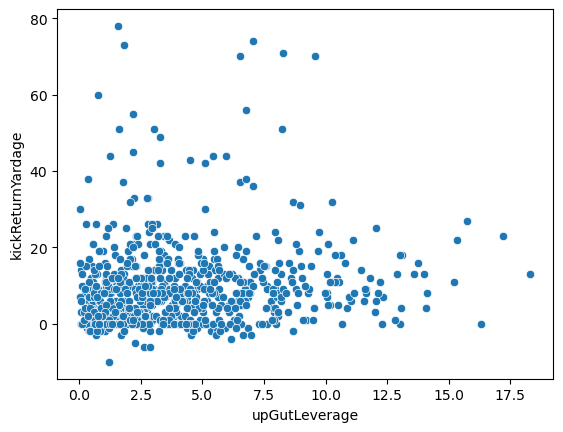

In [16]:
sns.scatterplot(data=temp_df.query('timeToCatch==0.0 & distOrder==1'), x='upGutLeverage', y='kickReturnYardage')

## Up the gut openness - horizontal gap between closest defenders on either side of returner - could be 2 players or player + sideline

## Returner speed at catch - absolute and downfield

In [17]:
temp_df = (modelbase_track_df
 # get location data of returner for each frame for modeling
 .merge(play_df.loc[~play_df.returnerId.astype(str).str.contains(';'), ## only consider plays with 1 returner
                    ['gameId','playId','returnerId']].astype({"returnerId": float}),
        how='inner',
        left_on=['gameId','playId','nflId'],
        right_on=['gameId','playId','returnerId'])
 .filter(['playDirection','gameId','playId','frameId','returnerId','s','dir','puntReceivedFrameId'])
 # filter to time of catch
 .query('frameId == puntReceivedFrameId')
 .drop(columns=['puntReceivedFrameId'])
 .assign(s_dwnfld = lambda df_: df_.s * -np.sin(np.deg2rad(df_.dir)))  # 0-180 degrees are backwards
 # attach return yardage (outcome)
 .merge(play_df[['gameId','playId','kickReturnYardage']],
        how='inner',
        on=['gameId','playId'])
).sort_values('s_dwnfld')
temp_df

,playDirection,gameId,playId,frameId,returnerId,s,dir,s_dwnfld,kickReturnYardage
751,left,2018091001,384,75,37251.0,7.10,65.19,-6.444700,10.0
332,left,2018111110,1095,79,45150.0,6.12,101.89,-5.988695,11.0
653,left,2018092400,4221,78,44946.0,6.19,107.68,-5.897631,16.0
473,left,2018101401,2661,76,44946.0,6.91,56.52,-5.763482,15.0
471,left,2018101401,1376,79,43663.0,5.92,109.97,-5.564040,6.0
...,...,...,...,...,...,...,...,...,...
599,left,2018092000,453,68,44837.0,7.43,311.59,5.557001,8.0
67,right,2018122308,3289,76,34683.0,5.80,271.79,5.797170,25.0
656,right,2018091600,773,72,46093.0,6.40,294.25,5.835277,5.0
475,left,2018101402,1005,73,44837.0,6.45,248.49,6.000781,13.0


In [79]:
# calculate by function
reload(nfl_bdb22)
nfl_bdb22.feat_returnerSpeedAtCatch(modelbase_track_df, play_df).sort_values('s_dwnfld')

,gameId,playId,s_dwnfld
33741,2018091001,384,-6.444700
14915,2018111110,1095,-5.988695
29282,2018092400,4221,-5.897631
21240,2018101401,2661,-5.763482
21152,2018101401,1376,-5.564040
...,...,...,...
26877,2018092000,453,5.557001
3010,2018122308,3289,5.797170
29417,2018091600,773,5.835277
21327,2018101402,1005,6.000781


## Number of defenders in 30 deg cone in front of returner (+/- 15 deg each side of downfield)

## Some feature to determine if gunner has beat vise